### 甲状腺の形から甲状腺の中心を見つける

1.　気管が画像内に存在している場合  
1.1. 気管の座標の範囲で縦方向に幅が一番小さくなる列を中心とする  
1.2 行方向の座標はプローブから取得  
1.3 行方向の座標を再計算する必要性あり(以下のアルゴリズムを用いる)  
2. 気管が画像内に存在していない場合(orアノテーションしない場合)  
2.1. 外接矩形の中心とプローブの位置関係を比較してエコー画像のどちら側(左端or右端)が甲状腺の中心に近いのか判定  
2.2. 甲状腺全体について、 甲状腺の幅を計測  
2.3. エコー画像の左(右)端からエコー画像の中心幅が最大になるまでの甲状腺の幅を抽出  
2.4. 最大幅の30%以下の幅を持つ甲状腺の列の中で最も皮膚に近い列を甲状腺の中心とする   

【座標再計算アルゴリズム】  
・外接矩形とプローブの座標とアノテーション済画像から抽出した甲状腺の画像を用いる  
Step1) 外接矩形の中心と甲状腺の中心の座標が合うようにする  
Step2) プローブの線とスキーマの交点を計算して、プローブの端点とする。   
step3) 端点と、甲状腺の中心の座標からもう一方の端点を計算する   

追加で考える必要があること  
① 甲状腺の端が存在しているか  
→ エコー画像の範囲と甲状腺の範囲を比較する エコー画像が四角でない場合は難しい  

②甲状腺に中心が写っているか  
1.or2.で指定した範囲における最小の幅が甲状腺の最大の幅の1/nになっているかどうかではんていする  

③皮膚からの距離も考慮に入れる  
→幅と両方考慮しないと腫瘍などで甲状腺が肥大化している場合に、誤識別する可能性あり  


## 甲状腺の端の推定

**step1　エコー領域と甲状腺の領域を比較** <br>
 <br>
 エコー領域:cutメソッドを用いて切り抜き <br>
 甲状腺: 幅を測定  
 判定基準: エコー領域の端から20ピクセル以内に甲状腺が存在していない→甲状腺の端が存在  
 
 **step2 甲状腺の端がエコー領域の台形に沿ってスライスされた形になっているかどうか判定**<br>
 <br>
 甲状腺の末端付近における各列の中央の座標の推移を観測→急激に減少している場合甲状腺の端は存在しない
 
 **step3 甲状腺の端の幅の大きさを用いて判定**  
   
 甲状腺の端から5ピクセルの幅の平均が20ピクセル以下で端が存在すると判定

In [52]:
import numpy as np
import cv2
import sys
import matplotlib.pyplot as plt
import matplotlib as mpl
import gc
import os
from tqdm import tqdm_notebook as tqdm
from pathlib import Path
import pandas as pd
from matplotlib.patches import Polygon
from collections import Counter
import statistics

from math import floor
from decimal import Decimal, ROUND_HALF_UP
import pprint

#from PatientClass import cut
from tensorflow import keras
from tensorflow.keras.models import model_from_json, load_model

%matplotlib inline
plt.gray()

<Figure size 432x288 with 0 Axes>

## 既存の関数の流用

In [53]:
def imgshow(img):
    cv2.namedWindow('image', cv2.WINDOW_NORMAL)
    cv2.imshow('image',img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

def imgplot(img):
    if len(img.shape) == 3:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(img)
    plt.show()
    
def grayscale(img):
    return np.uint8(cv2.cvtColor(img,cv2.COLOR_BGR2GRAY))

In [54]:
def is_integer_num(n):
    if isinstance(n, int):
        return 1
    if isinstance(n, float):
        if n.is_integer() == True:
            return 1
        else: return 0
    return False

In [55]:
def make_image_dic(image_namelist):
    image_dic = {}
    for i in image_namelist:
        img0 = cv2.imread(str(i))[40:-35,20:-15]
        print(i.stem,':',img0.shape)
        image_dic[i.stem] = img0
    return image_dic

def image_to_name(img,annotated_image_dic,return_name):
    image_name = [k for k, v in annotated_image_dic.items() if (v == img).all()]
    if return_name == True:
        return image_name[0]
    else:
        print('image_name:',image_name[0])

def annotated_to_image(img,annotated_image_dic,image_dic):
    annotated_image_name = image_to_name(img,annotated_image_dic,True)
    image_name = annotated_image_name.replace('annotated','')
    img0 = image_dic[image_name]
    return img0

In [56]:
#色を基に領域を抽出
def detect_color(img,bgrLower,bgrUpper):
    img_mask = cv2.inRange(img, bgrLower, bgrUpper) # BGRからマスクを作成
    result = cv2.bitwise_and(img, img, mask=img_mask)
    return result

#領域の最小列，最大列を計算
#甲状腺の場合
def measure_col_thy(img):
    #img = np.uint8(cv2.cvtColor(img,cv2.COLOR_BGR2GRAY))
    h,w  = img.shape
    n_min = 0
    n_max = 0
    for i in range(w-1):
        if np.count_nonzero(img[:,i]> 0)>0 and n_min==0 and np.count_nonzero(img[:,i+1]> 0)> 0:
            n_min += 1
            min_col = i
        if np.count_nonzero(img[:,w-1-i]> 0)>0 and n_max==0 and np.count_nonzero(img[:,w-1-i-1]> 0)> 0:
            n_max += 1
            max_col = w-1-i
    return min_col, max_col

#甲状腺以外
def measure_col(img):#関数名検討
    img = np.uint8(cv2.cvtColor(img,cv2.COLOR_BGR2GRAY))
    h,w  = img.shape
    n = 0
    for i in range(w):
        if np.count_nonzero(img[:,i]> 0)>0 and n==0 and np.count_nonzero(img[:,i+1]> 0)> 0:
            n += 1
            min_col = i
        elif img[:,i].sum() == 0 and n==1:
            n += 1
            max_col = i
    return min_col, max_col


#結節の位置を特定，dataframeを作成
def detect_nodule(img,image_name):
    img0 = np.uint8(cv2.cvtColor(img,cv2.COLOR_BGR2GRAY))
    h,w  = img0.shape
    n = 0.5
    df = pd.DataFrame(columns = ['image_name','part_number','min_col','max_col','part'])
    
    for i in range(w):
        if np.count_nonzero(img0[:,i]> 0)>1 and is_integer_num(n) == 0 and np.count_nonzero(img0[:,i+1]> 0)> 1:
            n += 0.5
            min_col = i
        elif img0[:,i].sum() == 0 and is_integer_num(n) == 1:
            n += 0.5
            max_col = i-1
            part_temp = img.copy()
            part_temp[:,:min_col] = np.array([0,0,0])
            part_temp[:,max_col+1:] =np.array([0,0,0])
            
            print('[nodule] number:',int(n))
            print('numbers of pixel:',np.count_nonzero(part_temp>0))
            imgplot(part_temp)
            print('min_col',min_col)
            print('max_col',max_col)
            
            df_temp = pd.Series([image_name,int(n), min_col, max_col, part_temp],index = df.columns)
            df = df.append(df_temp, ignore_index = True)
            
    return int(n),df
    
#bgr値を基とした各部位の抽出及び位置特定を行う
def detect_and_measure(img,bgrLower,bgrUpper,part_name,image_name=None):
    print('\n【',part_name,'】')
    Part = detect_color(img,bgrLower,bgrUpper)
    
    if np.count_nonzero(Part>0)<30:
        print(part_name,'is None')
        print('numbers of pixel:',np.count_nonzero(Part>0))
        if part_name == 'Nodule':
            return 0,0
        else:
            return 0,0,0,Part
    
    else:
        print(part_name,'is exist')
        
        if part_name == 'Thyroid':
            print('numbers of pixel:',np.count_nonzero(Part>0))
            imgplot(Part)
            min_col,max_col = measure_col_thy(Part)
            print('min_col',min_col)
            print('max_col',max_col)
            return 1,min_col,max_col,Part
        
        elif part_name == 'Nodule':
            n,df_nodule = detect_nodule(Part,image_name)
            
            return n,df_nodule
            
        else:
            print('numbers of pixel:',np.count_nonzero(Part>0))
            imgplot(Part)
            min_col,max_col = measure_col(Part)
            print('min_col',min_col)
            print('max_col',max_col)
            return 1,min_col,max_col,Part

In [57]:
#エコー画像からスキーマ部分の特定
def thyroid_detect(img):
    img_gray = np.uint8(cv2.cvtColor(img,cv2.COLOR_BGR2GRAY))
    imgplot(img_gray)
    
#edge
    c = cv2.Canny(img_gray,750,800)
    imgplot(c)
    
#フィルタ
    kernel = np.ones((50,50),np.float32)/500
    dst = cv2.filter2D(c,-1,kernel,borderType = cv2.BORDER_WRAP)
    imgplot(dst)

#中心を特定
    ct = np.int32(np.mean(np.where(dst==np.max(dst)),axis=-1))
    print('ct:',ct)
    
    return dst,ct

#エコー画像からスキーマ部分の切り出し
def thyroid_trim(img,dst,ct):
    t,b,l,r = 0,0,0,0
    s = 0
    while(s<4):
        s = 0
        if  dst[ct[0]-t,ct[1]] >= 85:
            t += 1
        else:
            s += 1
        if  dst.shape[0]>ct[0]+b and dst[ct[0]+b,ct[1]] >= 88:
            b += 1
        else:
            s += 1
        if  dst[ct[0],ct[1]-l] >= 88:
            l += 1
        else:
            s += 1
        if  dst.shape[1]>ct[1]+r and dst[ct[0],ct[1]+r] >= 88:
            r += 1
        else:
            s += 1

    #print('t:',t,',b:',b,',l:',l,',r',r)
    print('[{}:{},{}:{}]'.format(ct[0]-t,ct[0]+b,ct[1]-l,ct[1]+r))
    sc = img[ct[0]-t:ct[0]+b,ct[1]-l:ct[1]+r].copy()
    print('sc:')
    imgplot(sc)
    
    sc0 = np.uint8(cv2.cvtColor(sc,cv2.COLOR_BGR2GRAY))
    sc0[sc0<100] = 0
    sc[sc0==0] = 0
    print('sc0')
    imgplot(sc0)
    print('sc')
    imgplot(sc)
    
    return sc,[t,b,l,r]

In [58]:
def cut(img):

    mono_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) # np.sum(img, axis=2)
    #bin_img = np.sign(np.where((mono_img>140)&(mono_img<170), 0, mono_img))
    
    row_activate = np.zeros(mono_img.shape[0])
    col_activate = np.zeros(mono_img.shape[1])
    
    for row in range(mono_img.shape[0]):
        row_activate[row] = len(np.unique(mono_img[row]))
    for col in range(mono_img.shape[1]):
        col_activate[col] = len(np.unique(mono_img[:,col]))
    
    judge_len = 30
    judge_len_2 = 20
    min_unique_1 = 30
    min_unique_2 = 35
    
    top = 0
    bottom = mono_img.shape[0]-1
    for t in range(mono_img.shape[0]-judge_len):
        if all(row_activate[t:t+judge_len] >= min_unique_1):
            top = t
            for b in range(top+100, mono_img.shape[0]-judge_len_2):
                if all(row_activate[b:b+judge_len_2] < min_unique_2):
                    bottom = b
                    if b < top + 0.75*(mono_img.shape[0] - top):
                        bottom = int(top+ 0.75*(mono_img.shape[0] - top))
                        
                    break
            break

    judge_len = 30                             
    min_unique = 30
    left = 0
    right = mono_img.shape[1]-1
    for l in range(mono_img.shape[1]-judge_len):
        if all(col_activate[l:l+judge_len] >= min_unique):
            left = l
            for r in range(left + int(0.6*(mono_img.shape[1] - left)), mono_img.shape[1]):
                
                if all(col_activate[r:r+10] < min_unique) or len(np.where(mono_img[top:bottom,r]<6)[0])>bottom-top-60:
                    #print(r-10,r+10,col_activate[r-10:r+10])
                    #disp(img[:,r-10:r+10])
                    break
            right = r
            break

    return top, bottom, left, right

## 新規

In [59]:
# 孤立しているピクセルを取り除く
def clean_image(img):
    m,n = img.shape
    for i in range(1,m-1):
            for j in range(1,n-1):
                if (img[i,j] > 0 and img[i,j-1] == 0 and img[i,j+1] == 0 and img[i-1,j-1] == 0
                and img[i-1,j+1] == 0 and img[i+1,j-1] == 0 and img[i+1,j+1] == 0):
                    img[i,j] = 0
    return img

In [60]:
# スキーマ部分をマスクする
def image_mask_schema(img0):
    dst,ct = thyroid_detect(img0)
    sc, trim_range = thyroid_trim(img0,dst,ct)
    img = img0.copy()
    t,b,l,r = trim_range
    img[ct[0]-t:ct[0]+b,ct[1]-l:ct[1]+r]=0  
    return img

In [61]:
#甲状腺(thy)と結節(Nod)を抽出し，結合する
def make_img_Thy_Nod_Mal(img, Thy_Lower, Thy_Upper, Nod_Lower, Nod_Upper, Mal_Lower, Mal_Upper, threshold = 50):
    Thy = detect_color(img,Thy_Lower,Thy_Upper)
    Nod = detect_color(img,Nod_Lower,Nod_Upper)
    Mal = detect_color(img,Mal_Lower,Nod_Upper)

    Thy_gray = clean_image(np.uint8(cv2.cvtColor(Thy,cv2.COLOR_BGR2GRAY)))
    Nod_gray = clean_image(np.uint8(cv2.cvtColor(Nod,cv2.COLOR_BGR2GRAY)))
    Mal_gray = clean_image(np.uint8(cv2.cvtColor(Mal,cv2.COLOR_BGR2GRAY)))

    
    bitwise_temp = cv2.bitwise_or(Thy_gray, Nod_gray)
    bitwise_or = cv2.bitwise_or(bitwise_temp, Mal_gray)
    
    # 二値化(閾値を超えた画素を255にする。)
    ret, img_thy_nod_mal = cv2.threshold(bitwise_or, threshold, 255, cv2.THRESH_BINARY)
    imgplot(img_thy_nod_mal)
    
    return img_thy_nod_mal

In [62]:
#甲状腺(thy)と結節(Nod)を抽出し，結合する
def make_img_Thy_Nod(img, Thy_Lower, Thy_Upper, Nod_Lower, Nod_Upper, threshold = 50):
    Thy = detect_color(img,Thy_Lower,Thy_Upper)
    Nod = detect_color(img,Nod_Lower,Nod_Upper)

    Thy_gray = clean_image(np.uint8(cv2.cvtColor(Thy,cv2.COLOR_BGR2GRAY)))
    Nod_gray = clean_image(np.uint8(cv2.cvtColor(Nod,cv2.COLOR_BGR2GRAY)))

    bitwise_or = cv2.bitwise_or(Thy_gray, Nod_gray)

    # 二値化(閾値を超えた画素を255にする。)
    ret, img_thy_nod = cv2.threshold(bitwise_or, threshold, 255, cv2.THRESH_BINARY)
    imgplot(img_thy_nod)
    
    return img_thy_nod

In [63]:
#外接矩形からの中心とプローブの位置関係から甲状腺の中心の方向を判定
def judge_center_LR(df_horizonal,image_name):
    df_temp = df_horizonal[df_horizonal['image_name'] == image_name].reset_index(drop=True)
    cmax = df_temp['cmax'][0]
    th_min = df_temp['th_min'][0]
    th_max = df_temp['th_max'][0]
    
    if (th_min + th_max)/ 2 >= cmax:
        thy_LR = 'left'
    else:
        thy_LR = 'right'
        
    print('thy_LR:',thy_LR)
    return thy_LR

In [64]:
#甲状腺全体における各列の幅を計算
def clac_width_thy(img_thy_nod):
    m,n = img_thy_nod.shape
    min_list = []
    width_list = []
    for i in range(n):
        img_col = img_thy_nod[:,i]
        if (img_col != 0).any():
            nzero_list = np.where(img_col != 0)[0].tolist()
            min_temp = min(nzero_list)
            max_temp = max(nzero_list)
        
            width = max_temp - min_temp
        else:
            width = 0
            min_temp = 0
        
        width_list.append(width)
        min_list.append(min_temp)
        
    return min_list, width_list

In [65]:
#甲状腺の中心があるか判定
def judge_center_edge(min_width,max_width,img_thy_nod):
    if min_width > max_width * 0.3:
        center_exist = False
    else:
        center_exist = True
    
    return center_exist

In [66]:
#案②
#甲状腺の中心座標の特定
#幅が最大の幅の30%以下の列のなかで一番皮膚に近いところを中心として判定
def detect_center_thy(width_list_judge, max_width, cen_rate = 0.3):
    width_list_judge = np.array(width_list_judge)
    cen_col_list = np.where((width_list_judge <= max_width * cen_rate) & (width_list_judge != 0))[0].tolist()
    for i in cen_col_list:
        row_temp = np.inf
        for i in cen_col_list:
            if row_temp > min_list[i]:
                row_temp = min_list[i]
                min_col = i
    if thy_LR == 'right':
        min_col = img0.shape[1] - 1 - min_col
    
    return min_col

In [67]:
#スキーマのエッジの座標を計算
def calc_schema_edge(img,thy_list):
    thy_temp = [i for i in thy_list if (i != img).any()]

    plot_list = []
    edge_list = []
    m,n = img.shape

    #端点の座標計算
    for thy in thy_temp:
        x= thy[cd,:]
        num = 0
        if thy_LR == 'left':
            for i in range(n):
                if x[n-1-i] > 0 and num == 0:
                    num += 1
                    plot_list.append(n-1-i)
                elif x[n-1-i] > 0 and num == 1:
                    plot_list.append(n-1-i)
            
                elif x[n-1-i] == 0 and num == 1:
                    break
        else:
            for i,y in enumerate(x):
                if y > 0 and num == 0:
                    num += 1
                    plot_list.append(i)
                elif y > 0 and num == 1:
                    plot_list.append(i)
            
                elif y == 0 and num == 1:
                    break 
        edge = int(statistics.median(plot_list))
        edge_list.append(edge)

    if len(set(edge_list))>1:
        if Counter(edge_list).most_common(1)[0][0]/len(edge_list)>=0.5:
            edge = Counter(edge_list).most_common(1)[0][0]
        else:
            print('error: 各画像におけるプローブの位置が一致しません。それぞれの画像を確認してください。')
    else:
        edge = edge_list[0]
    print(edge)
    return edge      

In [68]:
def judge_edge(img0, img_thy_nod, thy_LR, edge_range=20):
    
    i0 = grayscale(annotated_to_image(img0,annotated_image_dic,image_dic)) # convert to gray scale
    top,bottom,left,right = cut(annotated_to_image(img0,annotated_image_dic,image_dic))
    i0_copy = i0.copy()
    l_edge,r_edge = measure_col_thy(img_thy_nod)
    
    print('left:{},right:{}'.format(left,right))
    print('l_edge:{},r_edge:{}'.format(l_edge,r_edge))
        
    imgplot(i0_copy)
    
    s_cen = np.zeros(i0.shape[1])
    width_list= []
    for i in range(img_thy_nod.shape[1]):
        img_temp = img_thy_nod[:,i]
        if (img_temp != 0).any():
            nzero_list = np.where(img_temp != 0)[0].tolist()
            min_temp = min(nzero_list)
            max_temp = max(nzero_list)
            width = max_temp - min_temp
            width_list.append(int(width))
            s_cen[i] = (min_temp + max_temp) / 2
        else:
            width_list.append(0)
    
    if (thy_LR == 'right' and left + edge_range <= l_edge) or (thy_LR =='left' and right - edge_range >= r_edge):
        print('a')
        edge_exist = True
    
    elif (thy_LR == 'right' and s_cen[l_edge + 4] - 20 >= s_cen[l_edge + edge_range]) or (thy_LR == 'left' and s_cen[r_edge - 4] - 20 >= s_cen[r_edge - edge_range]):
        print('b')
        edge_exist = False
        print(s_cen[l_edge + 4])
        print(s_cen[l_edge + edge_range])
        
    elif (thy_LR == 'right' and np.mean(np.array(width_list[l_edge:l_edge+5])) <= 20) or(thy_LR == 'left' and np.mean(np.array(width_list[r_edge-4:r_edge+1])) <= 20):
        print('c')
        edge_exist  = True
        
    else:
        print('d')
        edge_exist = False
        
        
    return edge_exist
    
    


In [69]:
data_path = Path().cwd()/'Patient 5'
print('data_path:',data_path)
#print('output_dir:',output_dir)

annotated_image_namelist = list(data_path.glob('annotatedImage*.jpg'))
image_namelist = list(data_path.glob('Image*.jpg'))

annotated_image_dic = make_image_dic(annotated_image_namelist)
annotated_image_list = list(annotated_image_dic.values())

image_dic = make_image_dic(image_namelist)
image_list = list(image_dic.values())

data_path: C:\Users\TatsuyaKawakami\Desktop\Azest\thyroid\Patient 5
annotatedImage002 : (443, 721, 3)
annotatedImage005 : (443, 721, 3)
annotatedImage007 : (443, 721, 3)
annotatedImage010 : (443, 721, 3)
annotatedImage011 : (443, 721, 3)
annotatedImage012 : (443, 721, 3)
annotatedImage013 : (443, 721, 3)
annotatedImage014 : (443, 721, 3)
annotatedImage015 : (443, 721, 3)
annotatedImage017 : (443, 721, 3)
annotatedImage018 : (443, 721, 3)
annotatedImage019 : (443, 721, 3)
annotatedImage020 : (443, 721, 3)
Image002 : (443, 721, 3)
Image005 : (443, 721, 3)
Image007 : (443, 721, 3)
Image010 : (443, 721, 3)
Image011 : (443, 721, 3)
Image012 : (443, 721, 3)
Image013 : (443, 721, 3)
Image014 : (443, 721, 3)
Image015 : (443, 721, 3)
Image017 : (443, 721, 3)
Image018 : (443, 721, 3)
Image019 : (443, 721, 3)
Image020 : (443, 721, 3)


In [70]:
#Thyroid
Thy_Lower = np.array([50, 150, 0])# 抽出する色の下限(BGR)
Thy_Upper = np.array([140, 240, 70])# 抽出する色の上限(BGR)

#Trachea
Tra_Lower = np.array([75, 160, 160])
Tra_Upper = np.array([150, 240, 240])

#Nodule
Nod_Lower = np.array([0, 20, 100])
Nod_Upper = np.array([60, 100, 200])

#Artery
Art_Lower = np.array([140, 50, 0])
Art_Upper = np.array([250, 150, 60])


#Malignant
Mal_Lower =  np.array([140, 50, 0])
Mal_Upper = np.array([250, 150, 60])


In [71]:
df_probe_fixed = pd.read_pickle('df_probe_fixed_patient5.pickle')

## main

annotatedImage005


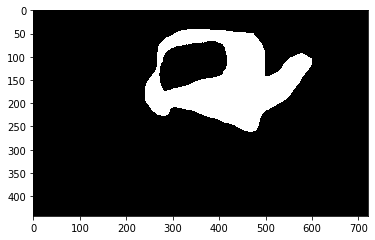

thy_LR: right
min_width: 5
max_width: 213
left:39,right:630
l_edge:240,r_edge:600


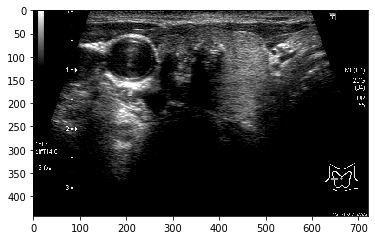

a
center: True
edge: True
22
th_min: 22
th_max: 40
annotatedImage010


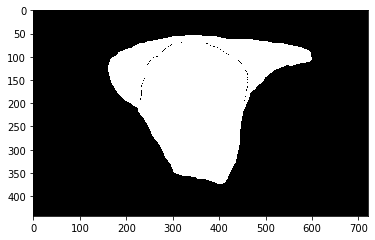

thy_LR: right
min_width: 7
max_width: 317
left:37,right:597
l_edge:162,r_edge:599


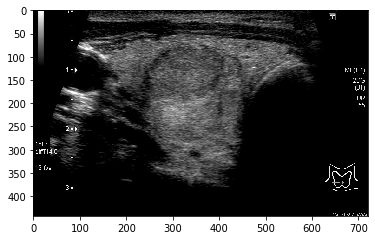

a
center: True
edge: True
22
th_min: 22
th_max: 40
annotatedImage017


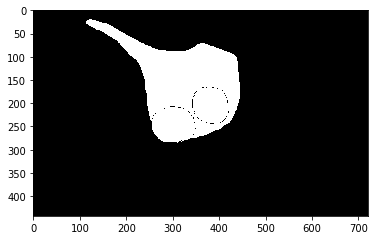

thy_LR: left
min_width: 2
max_width: 199
left:91,right:638
l_edge:113,r_edge:445


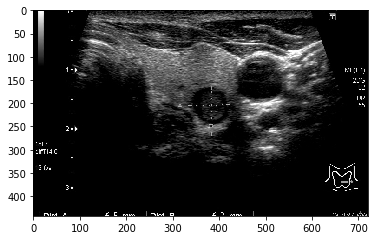

a
center: True
edge: True
58
th_min: 39
th_max: 58
annotatedImage020


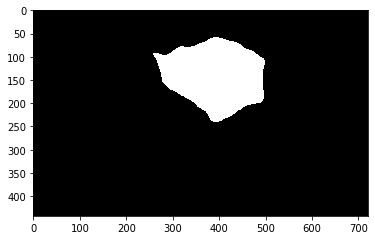

thy_LR: left
min_width: 1
max_width: 181
left:108,right:643
l_edge:258,r_edge:499


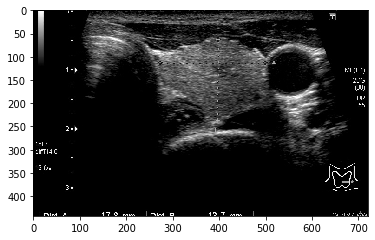

a
center: True
edge: True
56
th_min: 40
th_max: 56


In [72]:
df_horizonal = df_probe_fixed[df_probe_fixed['direction'] == 'horizonal'].reset_index(drop=True)

if len(df_horizonal) > 0:
    for i,image_name in enumerate(df_horizonal['image_name'].to_numpy().tolist()):
        print(image_name)
        img0 = annotated_image_dic[image_name]
        
        # 色で各部位を抽出するときにプローブの色が干渉するので、スキーマを削除
        #img = image_mask_schema(img0)
        
        #結節と甲状腺のみを抽出した画像作成
        img_thy_nod = make_img_Thy_Nod(img0, Thy_Lower, Thy_Upper, Nod_Lower, Nod_Upper)
        
        #甲状腺の中心がエコー画像のどちら側にあるか判定
        thy_LR = judge_center_LR(df_horizonal, image_name) 
        
        #甲状腺の各列の幅と皮膚との距離を計算
        min_list, width_list = clac_width_thy(img_thy_nod)
        max_width = max(width_list) 
        
        #探索する列を決定
        if thy_LR == 'left':
            col_max = np.where(np.array(width_list) == max_width)[0][0]
            width_list_judge = width_list[:col_max+1]
            min_list_judge = min_list[:col_max+1]
        elif thy_LR == 'right':
            col_max = np.where(np.array(width_list) == max_width)[0][-1]
            width_list_judge = width_list[-1:col_max-1:-1]
            min_list_judge = min_list[-1:col_max-1:-1]

        min_width = min([i for i in width_list_judge if i>0])

        print('min_width:',min_width)
        print('max_width:',max_width)
        
        '''
        ===================================================
        #甲状腺の中心があるか判定(ここでedgeの判定もしたい)
        '''
        center_exist = judge_center_edge(min_width,max_width,img_thy_nod)
        edge_exist = judge_edge(img0, img_thy_nod, thy_LR)
        '''
        #甲状腺の端が存在しているか要検討
        ===================================================
        '''
        print('center:',center_exist)
        print('edge:',edge_exist)
        
        if center_exist == True and edge_exist == True:
        #中心の座標(列)
            min_col = detect_center_thy(width_list_judge, max_width, cen_rate = 0.3)
            
            #プローブの座標
            cd = df_probe_fixed['cd'][i]
            th_min = df_probe_fixed['th_min'][i]
            th_max = df_probe_fixed['th_max'][i]
            
            #甲状腺の座標
            cmax = df_probe_fixed['cmax'][i]
            l_edge,r_edge = measure_col_thy(img_thy_nod)

            #スキーマ
            img_thy = df_probe_fixed['thy'][i]
            thy_list =  list(df_probe_fixed['thy'])
            edge = calc_schema_edge(img_thy, thy_list)
            
            if thy_LR == 'right' and center_exist == True:
                th_min = edge
                th_max = int(edge + (cmax - edge) * (r_edge-l_edge)/(min_col - l_edge))

            elif thy_LR == 'left' and center_exist == True:
                th_min = int(edge - (edge - cmax) * (r_edge-l_edge)/(r_edge - min_col))
                th_max = edge
                
            print('th_min:',th_min)
            print('th_max:',th_max)
    
            df_probe_fixed['th_min'].mask(df_probe_fixed['image_name'] == image_name, th_min ,inplace = True)
            df_probe_fixed['th_max'].mask(df_probe_fixed['image_name'] == image_name, th_max ,inplace = True)

## テスト


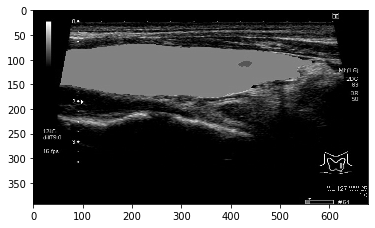

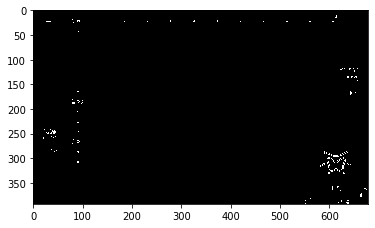

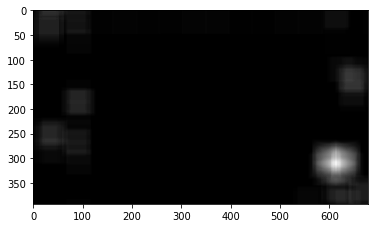

ct: [309 614]
[276:335,577:651]
sc:


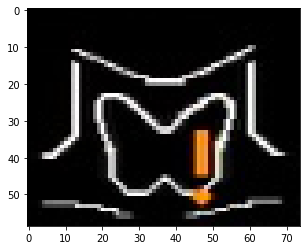

sc0


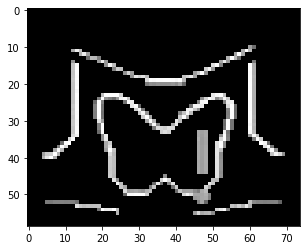

sc


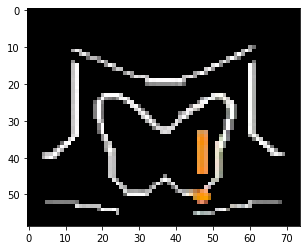

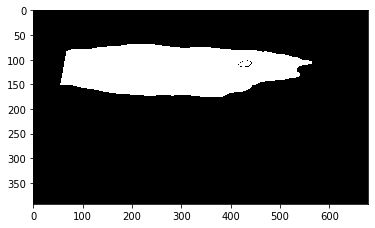

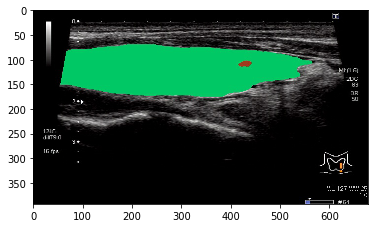

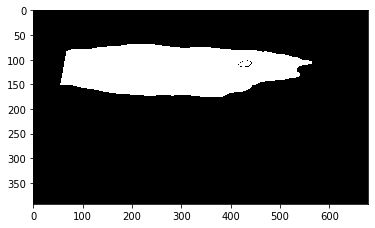

left:52,right:622
l_edge:55,r_edge:565


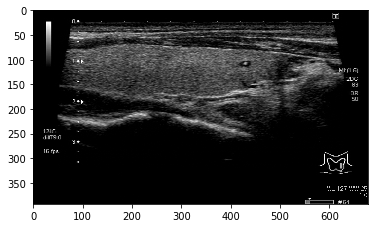

b
138.5
116.0
False


In [265]:
img0 = annotated_image_list[6]
#i0 = grayscale(annotated_to_image(img0,annotated_image_dic,image_dic))# convert to gray scale
img = image_mask_schema(img0)
img_thy_nod = make_img_Thy_Nod(img, Thy_Lower, Thy_Upper, Nod_Lower, Nod_Upper)

thy_LR = 'right'
imgplot(img0)
imgplot(img_thy_nod)

print(judge_edge(img0, img_thy_nod, thy_LR, edge_range=20))

image_name: annotatedImage003


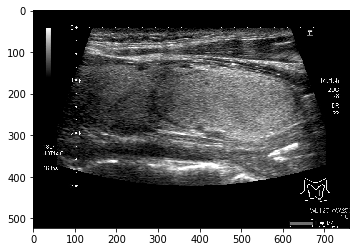

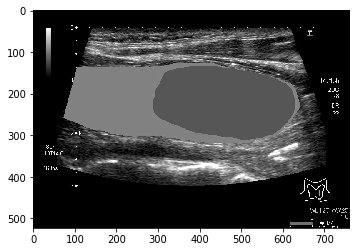

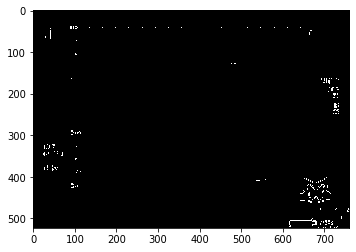

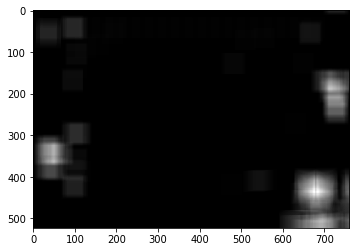

ct: [435 678]
[399:474,638:719]
sc:


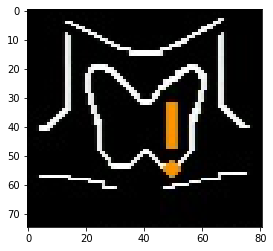

sc0


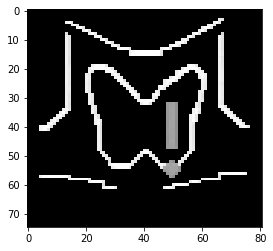

sc


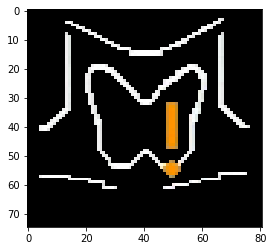

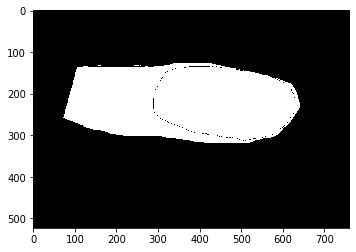

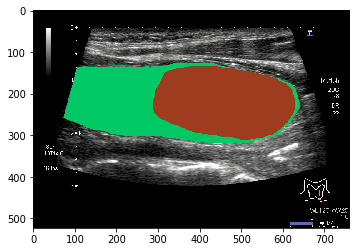

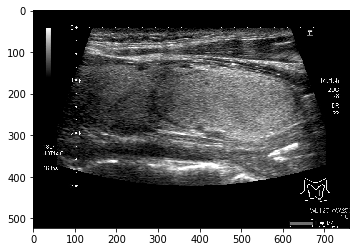

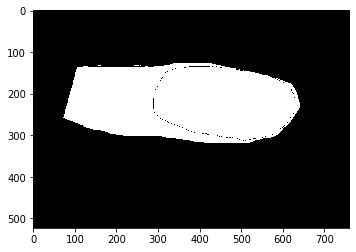

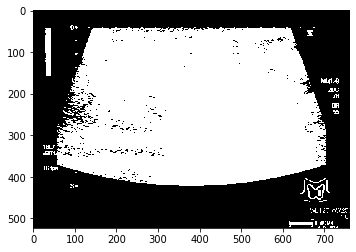

ピクセルの輝度のsum


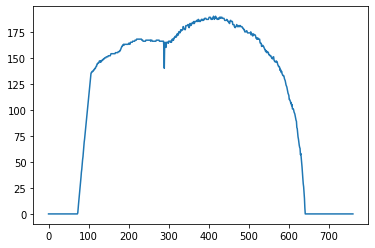

ピクセル数


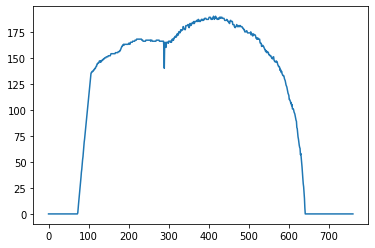

甲状腺の中心


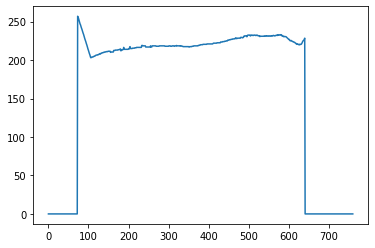

[229.5 227.5 226.  224.5 222.5 221.  219.5 217.5 215.5 214.  212.5 210.5
 209.  207.5 206.  204.  203.  203.5 203.5 204. ]
[ 72  76  81  84  88  93  96 100 104 107 112 116 121 124 129 133 135 136
 136 137]


In [200]:
#2,4
img0 = annotated_image_list[1]
i0 = grayscale(annotated_to_image(img0,annotated_image_dic,image_dic))# convert to gray scale
imgplot(i0)

# 色で各部位を抽出するときにプローブの色が干渉するので、スキーマを削除
img = image_mask_schema(img0)

#top,bottom,left,right = cut(img0)
#img = img0[top:bottom,left:right]

#結節と甲状腺のみを抽出した画像作成
img_thy_nod = make_img_Thy_Nod(img, Thy_Lower, Thy_Upper, Nod_Lower, Nod_Upper)

#i0 = i0[top:bottom,left:right]

imgplot(img0)
imgplot(i0)
imgplot(img_thy_nod)

# 閾値の設定
threshold = 5
# 二値化(閾値を超えた画素を255にする。)
ret, img_bit = cv2.threshold(i0, threshold, 255, cv2.THRESH_BINARY)
imgplot(img_bit)

col_binarize = np.count_nonzero(img_bit > 0, axis = 0)
col_diff = np.diff(np.array(col_binarize), n= 1)

#for col in range(img_bit.shape[1]):
    
s_binarize = np.count_nonzero(img_thy_nod > 0, axis = 0)
s_cen = np.zeros(img.shape[1])

for i in range(img_thy_nod.shape[1]):
    img_temp = img_thy_nod[:,i]
    if (img_temp != 0).any():
        nzero_list = np.where(img_temp != 0)[0].tolist()
       # print(nzero_list)
        min_temp = min(nzero_list)
        max_temp = max(nzero_list)
        s_cen[i] = (min_temp + max_temp) / 2
    
    
s = np.sum(img_thy_nod, axis=0)/255
s2 = np.sum(i0,axis=0)/255

col_activate = np.zeros(i0.shape[1])
for col in range(i0.shape[1]):
    col_activate[col] = len(np.unique(i0[:,col]))
    
x = np.arange(s.shape[0])
print('ピクセルの輝度のsum')
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x,s) # plot x and s (upper-left image)
plt.show()

print('ピクセル数')
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x,s_binarize) # plot x and s (upper-left image)
plt.show()

print('甲状腺の中心')
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x,s_cen) # plot x and s (upper-left image)
plt.show()

print(s_cen[90:110])
print(s_binarize[90:110])



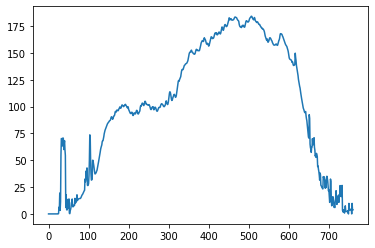

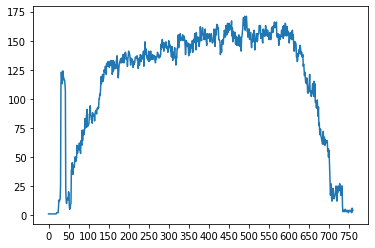

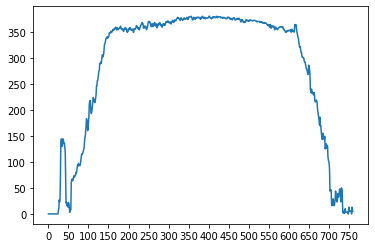

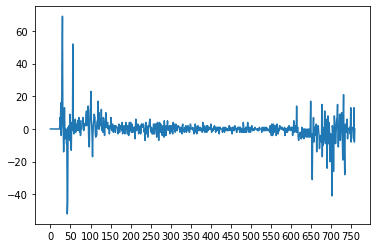

In [199]:

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x,s2) # plot x and s2 (upper-right image)

plt.show()
fig = plt.figure()
ax = fig.add_subplot(111)
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(50))
ax.plot(x,col_activate) # plot x and col_activate (lower-left image)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(50))
ax.plot(x,col_binarize) # plot x and col_activate (lower-left image)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(50))
x = np.arange(s.shape[0]-1)
ax.plot(x,col_diff) # plot x and col_activate (lower-left image)

plt.show()


### 没

In [116]:
#中心の探索    
#案①
#幅最大→皮膚に一番近い

cen_col_list = np.where(np.array(width_list_judge) == min_width)[0].tolist()

if len(cen_col_list) > 1: 
    row_temp = img0.shape[0]
    for i in cen_col_list:
        if row_temp > min_list[i]:
            row_temp = min_list[i]
            min_col = i
else:
    min_col = cen_col_list[0]

if thy_LR == 'right':
    min_col = img0.shape[1] - 1 - min_col

print(min_col)


113


## 甲状腺の深さ計測

In [5]:
def extscale(img,top,bottom,left):
    
    #img = pobj.orgimage[index].copy()
    #top,bottom,left = pobj.top, pobj.bottom, pobj.left
    i2 = img.copy()
    
    
    # convert BGR image to gray scale
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    mask = cv2.inRange(img,160,255)
    img[mask==0]=0  # All pixels below 160 becomes 0
    mx = np.max(img[:,:left])  # max pixel value 
    minmax = np.min([200,mx])
    print(top,bottom,left,mx,img.shape)
    
    crp = top - 10  # current row position
    prp = crp        # previous row position
    length = 0
    plength = 0
    repetition = 0
    col = []
    flist = []  # stores the pixel length between subsequent points in a column

    for c in range(left):
        crp = np.max([0,top - 10])
        prp = 0
        length = 0
        repetition = 0
        plength = 0
        
        while crp>=0 and crp<(bottom -10):
            crp += 1
         
            if img[crp,c]> minmax:
                
                if prp==0 and prp!=crp:
                    
                    prp = crp
                    crp += 15
                
                elif length==0 and prp!=crp  and np.average(img[crp-prp:crp,c])>10 and np.average(img[crp-prp:crp,c])<100:
                   
                    length = (crp-prp)
                    prp = crp
                    crp += 15
                    
                elif length!=0 and (crp-prp)>0.9*length and (crp-prp)<1.10*length and length>15 and np.average(img[crp-prp:crp,c])>=10 and np.average(img[crp-prp:crp,c])<100:
                   
                    plength = length
                    length = crp-prp
                    
                    repetition += 1                    
                    if repetition >= 3:
                        flist.append((crp,length,plength))
                        print('* ',c,crp,prp,prp-plength)
                        col.append(c)
                        repetition = 0
                        break
                    prp = crp
                    crp += 15
                    
                elif length!= 0 and ((crp-prp)<=0.9*length or (crp-prp)>=1.1*length):
                    length = crp-prp
                    prp = crp
                    crp += 15
                    
        if len(col)!=0:
            break
        
    print(col,flist)
    
    if len(col)!=0:
        cv2.imshow('scale',np.concatenate((np.concatenate((np.zeros([flist[0][0]+30-max(top-10,0),100]),img[max(top-10,0):flist[0][0]+30,col[-1]:col[-1]+1]),axis=1),np.zeros([flist[0][0]+30-max(top-10,0),100])),axis=1))
        #cv2.imwrite('C:\\Users\\AZEST-2019-07\\Desktop\\pyfiles\\scale.png',cv2.resize(img[0:row+15,col-32:col+32], dsize=(128,2*(row+15))))
    
    i2[:,col] = [0,100,255]
    cv2.imshow('org',i2[max(top-10,0):flist[0][0]+30,:left])
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    return col[0],flist[0]


In [6]:
def load_model2():
    path = Path().cwd()/'model'
    model = load_model(str(path/'mymodel.h5'))
    model.load_weights(str(path/'best_weights.hdf5'))
    opt = keras.optimizers.Adam(lr=0.0002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    return model

def getdist(img,col,top,bottom,flist):
    
    img = img.copy()
   # cnn model trained on decimal mnist
    model = load_model2()

     # maps model output to numbers
    num_dict = {}
    for i in range(10):
        num_dict[i] = i
        num_dict[10+i] = i+0.5

    num_dict[20] = -1
    
    colslice = img[max(top-10,0):min(flist[0]+30,bottom),col:col+1]
    mask = cv2.inRange(img,100,255)
    img[mask == 0] = 0
    img = img[max(top-10,0):min(flist[0]+30,bottom),:]
    print(colslice.shape)
    row,column = colslice.shape
    peak = []
    pr = 0  #row which has the point
    corr = 0
    for r in range(row):    
        if colslice[r,0] >= 140:
            pr = r
            corr += 1
        elif pr!=0:
            peak.append(pr-round(corr/2))
            corr = 0
            pr = 0
    
    #print(peak,i1.shape)
    d = 0
    lor = ''    # left side(l) or right side(r)
    dist = []
    l0 = 0
    r0 = 0
    
    for pos in peak:
        lside = img[pos-14:pos+14,col-29:col-1]
        rside = img[pos-14:pos+14,col+1:col+29]
        if lside.shape == (28,28) and rside.shape == (28,28):
            l = num_dict[np.argmax(model.predict(lside.reshape(1,28,28,1)/255))]
        
            r = num_dict[np.argmax(model.predict(rside.reshape(1,28,28,1)/255))]
           
            if l == 0 and lor=='':
                lor = 'l'
                d = pos
            elif r == 0 and lor=='':
                lor = 'r'
                d = pos
            elif lor=='l' and (l == 1 or l == 2 or l == 0.5):
                #print((pos-d)/(l-l0),m,l,l0,pos)
                print('l:',l)
                print('pos:',pos)
                print('d:',d)
                dist.append((pos-d)/(l-l0))
                d = pos
                l0 = l
            elif lor=='r' and (r == 1 or r == 2 or r == 0.5):
                #print((pos-d)/(r-r0),m,r,r0,pos)
                dist.append((pos-d)/(r-r0))
                d = pos
                r0 = r
       
        #cv2.imshow('l',lside)
        #cv2.imshow('r',rside)
        #cv2.waitKey(0)
        #cv2.destroyAllWindows()
    return peak,np.average(dist)

image_name: annotatedImage001


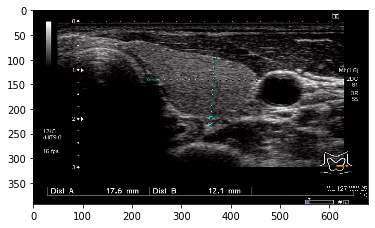

6 323 49 659


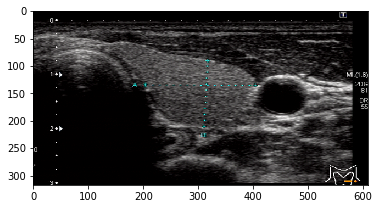

image_name: annotatedImage003


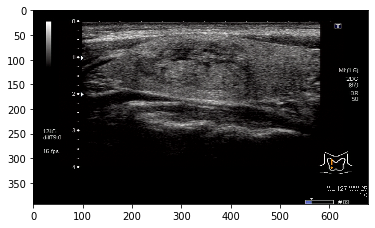

18 330 99 583


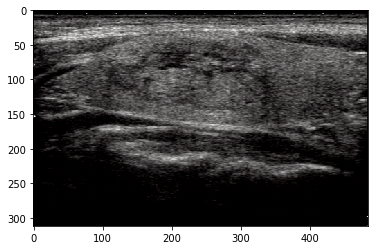

image_name: annotatedImage007


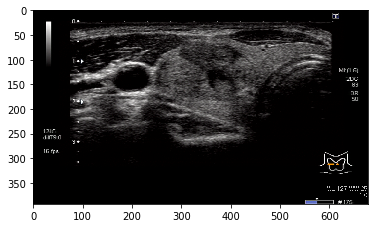

6 330 75 633


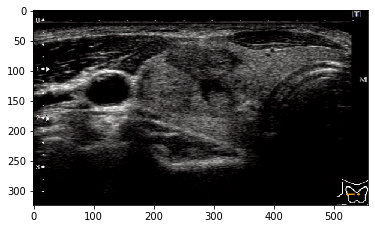

image_name: annotatedImage008


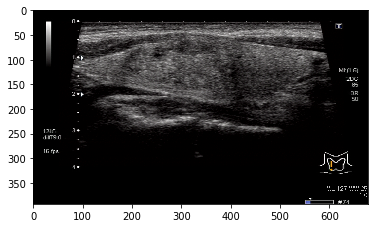

17 330 79 615


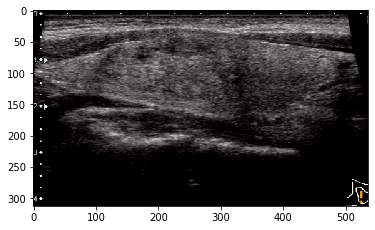

image_name: annotatedImage009


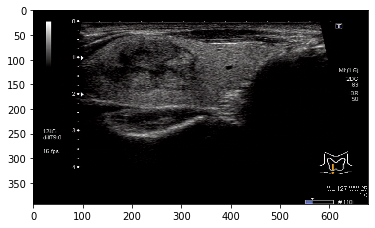

16 332 88 611


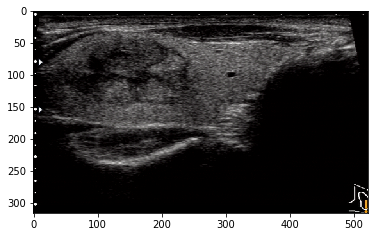

image_name: annotatedImage010


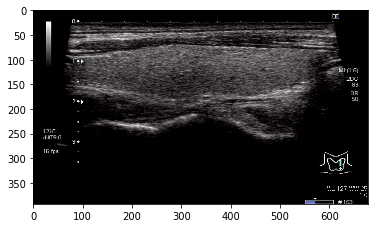

6 330 64 633


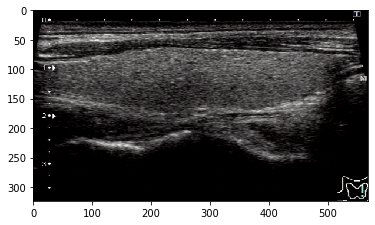

image_name: annotatedImage011


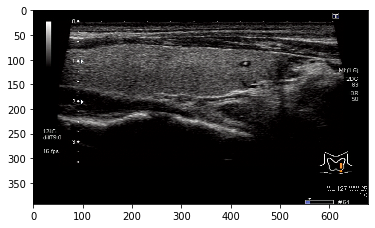

6 330 52 635


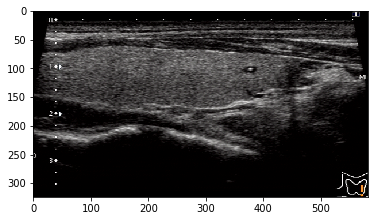

In [65]:
for i in tqdm(annotated_image_list[:7]):
    img = annotated_to_image(i,annotated_image_dic,image_dic)
    imgplot(img)
    #imgshow(img)
    t,b,l,r = cut(img)
    print(t,b,l,r)
    img = img[t:b:,l:r]
    imgplot(img)
    #x,y = extscale(img,t,b,l)
    

image_name: annotatedImage007


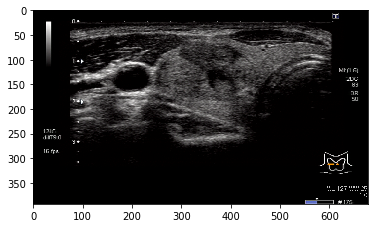

6 330 75 633


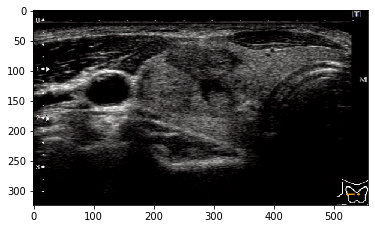

6 330 75 255 (324, 558)
*  15 260 220 178
[15] [(260, 40, 42)]
(290, 1)


C:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:392: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [66]:
i = annotated_image_list[2]
img = annotated_to_image(i,annotated_image_dic,image_dic)
imgplot(img)
#imgshow(img)
top,bottom,left,right = cut(img)
print(top,bottom,left,right)
img = img[top:bottom:,left:right]
imgplot(img)
col,flist = extscale(img,top,bottom,left)
img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
peak, dist = getdist(img_gray,col,top,bottom,flist)
    
#annotated_img = i[t:b,l:r]
#imgplot(annotated_img)
#imgplot(img)
#a,b = extscale(img,t,b,l)